

> TFG (No es la version final)




1.   Importación de datos
2.   Preprocesamiento de los datos
3.   Modelo de clasificacion (transfer learning y modelo simple)
4.   Modelo de segmentacion con los resultados del modelo anterior
5.   Representacion de los resultados




# Librerias

In [1]:
import zipfile
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16, ResNet50
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Importación de los datos


In [2]:
def extract_zip(zip_path, dest_dir):
    """
    Extrae el contenido de un archivo zip a un directorio de destino.

    Args:
        zip_path (str): La ruta al archivo zip.
        dest_dir (str): El directorio donde se extraerán los archivos.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)

# Define las rutas del archivo zip y el directorio de destino
zip_file_path = '/content/archive.zip'
destination_directory = '/content'

# Llama a la función para extraer el archivo
if os.path.exists(zip_file_path):
    extract_zip(zip_file_path, destination_directory)
    print(f"Archivo '{zip_file_path}' extraído a '{destination_directory}'")
else:
    print(f"El archivo '{zip_file_path}' no fue encontrado.")

Archivo '/content/archive.zip' extraído a '/content'


In [3]:
def importar(folder_path):
    image_list = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path)
                image_list.append(img)
            except Exception as e:
                print(f"No se pudo abrir la imagen {filename}: {e}")
    return image_list

In [4]:
imagenes_ct_sanas = importar('/content/Dataset/Brain Tumor CT scan Images/Healthy')
imagenes_ct_tumor = importar('/content/Dataset/Brain Tumor CT scan Images/Tumor')
imagenes_mri_sanas = importar('/content/Dataset/Brain Tumor MRI images/Healthy')
imagenes_mri_tumor = importar('/content/Dataset/Brain Tumor MRI images/Tumor')

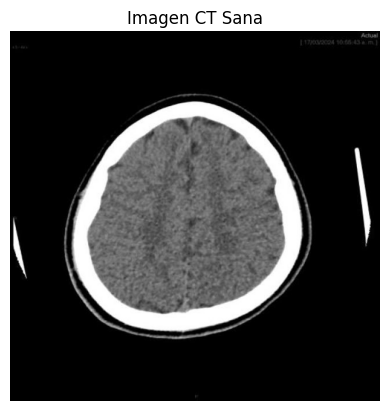

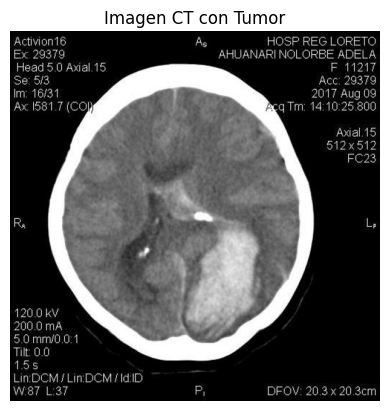

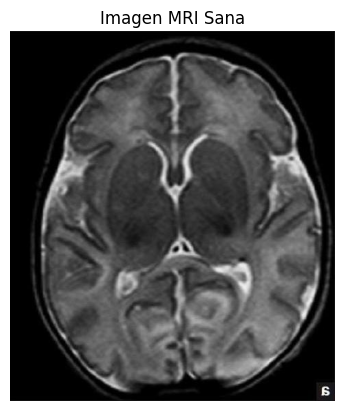

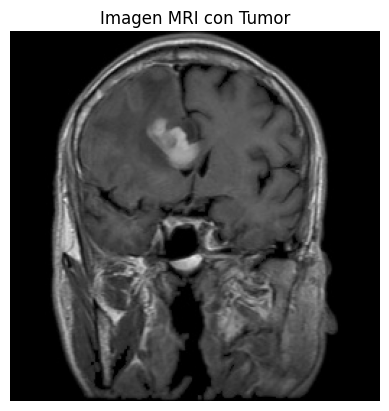

In [5]:
def display_image(image_list, title):
    if image_list:
        random_index = np.random.randint(0, len(image_list))
        plt.imshow(image_list[random_index], cmap='grey')
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print(f"La lista '{title}' está vacía.")

display_image(imagenes_ct_sanas, "Imagen CT Sana")
display_image(imagenes_ct_tumor, "Imagen CT con Tumor")
display_image(imagenes_mri_sanas, "Imagen MRI Sana")
display_image(imagenes_mri_tumor, "Imagen MRI con Tumor")

# 2. Preprocesamiento de los datos

In [6]:
def preprocess_images(image_list, target_size=(256, 256)):
    processed_images = []
    for img in image_list:
        # Convierto a array NumPy y asegurar que sea RGB
        img_array = np.array(img.convert('RGB')) if img.mode != 'RGB' else np.array(img)
        # Redimensiono todas las imágenes al mismo tamaño objetivo
        resized_img = cv2.resize(img_array, target_size)
        # Normalizo (escalar los valores de píxel a un rango de 0 a 1)
        normalized_img = resized_img.astype('float32') / 255.0
        processed_images.append(normalized_img)
    return processed_images

imagenes_ct_sanas_processed = preprocess_images(imagenes_ct_sanas)
imagenes_ct_tumor_processed = preprocess_images(imagenes_ct_tumor)
imagenes_mri_sanas_processed = preprocess_images(imagenes_mri_sanas)
imagenes_mri_tumor_processed = preprocess_images(imagenes_mri_tumor)

print(f"Se preprocesaron {len(imagenes_ct_sanas_processed)} imágenes CT sanas.")
print(f"Se preprocesaron {len(imagenes_ct_tumor_processed)} imágenes CT con tumor.")
print(f"Se preprocesaron {len(imagenes_mri_sanas_processed)} imágenes MRI sanas.")
print(f"Se preprocesaron {len(imagenes_mri_tumor_processed)} imágenes MRI con tumor.")

Se preprocesaron 2300 imágenes CT sanas.
Se preprocesaron 2318 imágenes CT con tumor.
Se preprocesaron 2000 imágenes MRI sanas.
Se preprocesaron 3000 imágenes MRI con tumor.


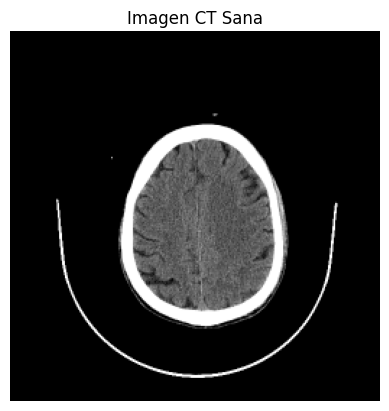

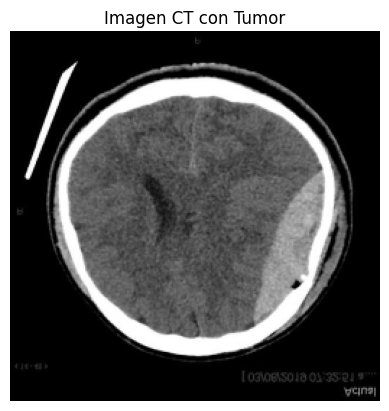

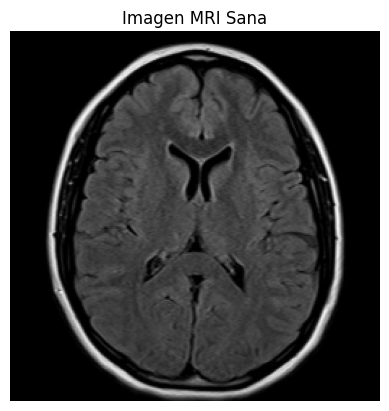

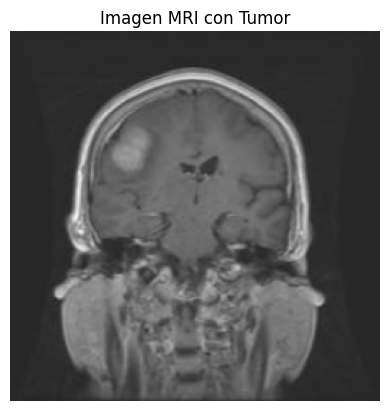

In [7]:
display_image(imagenes_ct_sanas_processed, "Imagen CT Sana")
display_image(imagenes_ct_tumor_processed, "Imagen CT con Tumor")
display_image(imagenes_mri_sanas_processed, "Imagen MRI Sana")
display_image(imagenes_mri_tumor_processed, "Imagen MRI con Tumor")

# 3. Modelo de clasificación conjunto ct

Uso modelos preentrenados para clasificación, los modelos que voy a usar son VGG16 y RESNET50.

## VGG16

### Modelo completo

In [15]:
imagenes_ct = imagenes_ct_sanas_processed + imagenes_ct_tumor_processed
# 0 para sanas, 1 para tumor
labels_ct = [0] * len(imagenes_ct_sanas_processed) + [1] * len(imagenes_ct_tumor_processed)
imagenes_ct = np.array(imagenes_ct)
labels_ct = np.array(labels_ct)
X_train_ct, X_test_ct, y_train_ct, y_test_ct = train_test_split(
    imagenes_ct, labels_ct,
    test_size=0.2, random_state=42, stratify=labels_ct)
print(f"Tamaño del conjunto de entrenamiento: {len(X_train_ct)}")
print(f"Tamaño del conjunto de prueba: {len(X_test_ct)}")

Tamaño del conjunto de entrenamiento: 3694
Tamaño del conjunto de prueba: 924


In [ ]:
# Cargo el modelo base VGG16 preentrenado en ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,722,913 (56.16 MB)

 Trainable params: 14,722,913 (56.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train_ct, y_train_ct, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 61s 470ms/step - accuracy: 0.5088 - loss: 1.1899 - val_accuracy: 0.4993 - val_loss: 0.6753
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.5574 - loss: 0.6752 - val_accuracy: 0.8687 - val_loss: 0.3229
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.8891 - loss: 0.3071 - val_accuracy: 0.9093 - val_loss: 0.3176
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9217 - loss: 0.2224 - val_accuracy: 0.9432 - val_loss: 0.1961
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9371 - loss: 0.1753 - val_accuracy: 0.9405 - val_loss: 0.2146
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9388 - loss: 0.1794 - val_accuracy: 0.9364 - val_loss: 0.1882
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9390 - loss: 0.1772 - val_accuracy: 0.9418 - val_loss: 0.2086
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9390 - loss: 0.1632 - val_accuracy: 0

In [ ]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9661 - loss: 0.1361
Pérdida en el conjunto de prueba: 0.1598
Precisión en el conjunto de prueba: 0.9600


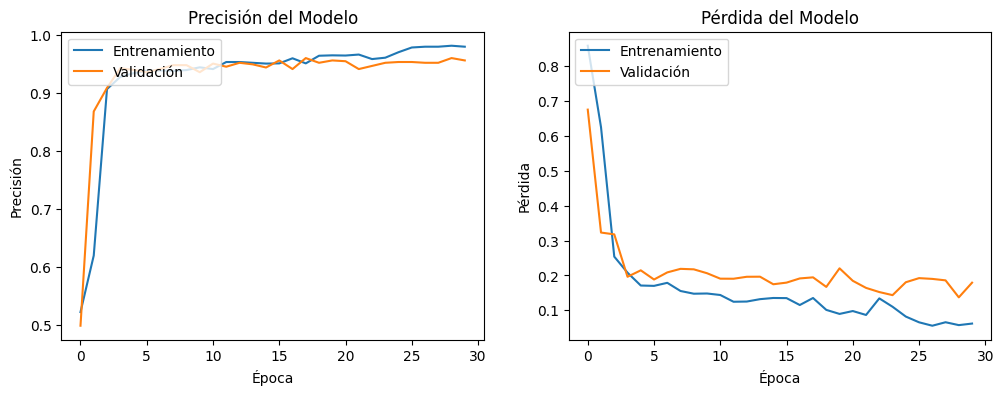

In [ ]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


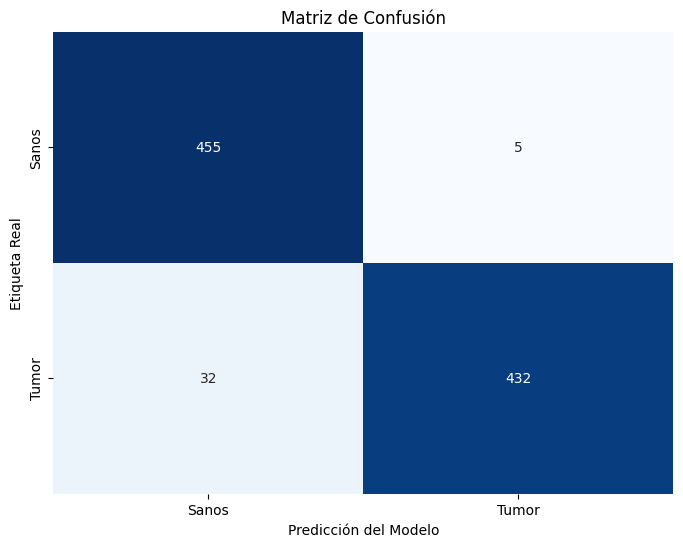

In [ ]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo con capas congeladas

In [22]:
# Cargo el modelo base VGG16 preentrenado en ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [23]:
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,784,513 (56.40 MB)

 Trainable params: 69,825 (272.75 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
history = model.fit(X_train_ct, y_train_ct, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 0.7684 - loss: 0.5258 - val_accuracy: 0.8972 - val_loss: 0.3258
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8978 - loss: 0.2673 - val_accuracy: 0.8985 - val_loss: 0.2567
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9131 - loss: 0.2220 - val_accuracy: 0.9337 - val_loss: 0.2265
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9403 - loss: 0.1826 - val_accuracy: 0.8985 - val_loss: 0.2892
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9296 - loss: 0.1968 - val_accuracy: 0.9107 - val_loss: 0.2245
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9493 - loss: 0.1540 - val_accuracy: 0.9283 - val_loss: 0.2035
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9410 - loss: 0.1677 - val_accuracy: 0.9378 - val_loss: 0.2227
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9516 - loss: 0.1488 - val_accuracy: 0.9445 -

In [25]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9706 - loss: 0.1089
Pérdida en el conjunto de prueba: 0.1321
Precisión en el conjunto de prueba: 0.9632


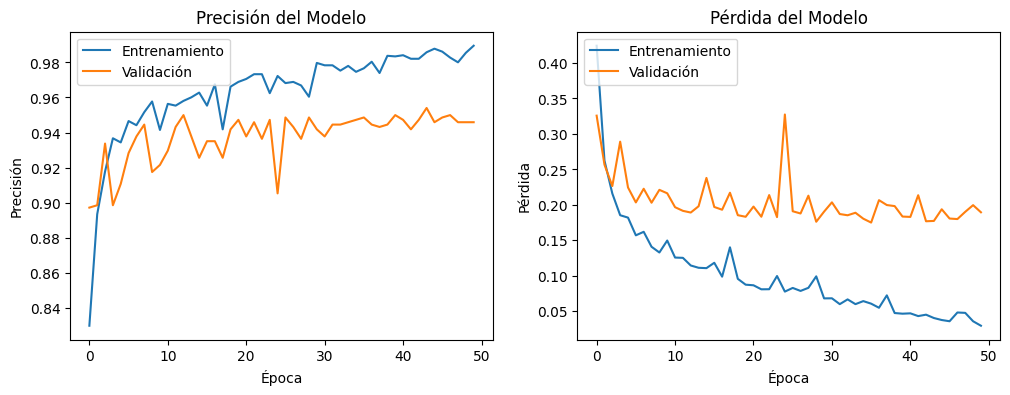

In [26]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step


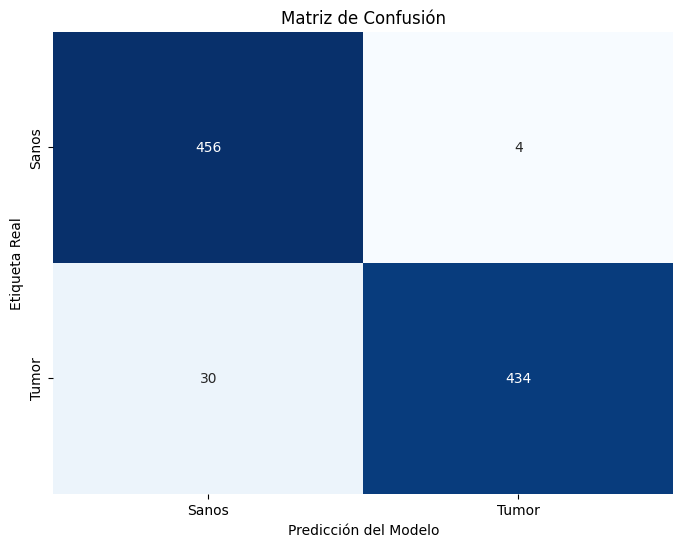

In [27]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo con x capas congeladas

In [35]:
# Cargo el modelo base VGG16 preentrenado en ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [36]:
base_model.trainable = True

capas_a_congelar = 17


for layer in base_model.layers[:capas_a_congelar]:
    layer.trainable = False

In [37]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
#x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
#x = Dense(16, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,883,073 (56.77 MB)

 Trainable params: 2,528,193 (9.64 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [38]:
history = model.fit(X_train_ct, y_train_ct, epochs=35, batch_size=64, validation_split=0.2)

Epoch 1/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 242ms/step - accuracy: 0.7048 - loss: 0.4947 - val_accuracy: 0.9405 - val_loss: 0.2066
Epoch 2/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9454 - loss: 0.1603 - val_accuracy: 0.9378 - val_loss: 0.1865
Epoch 3/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9545 - loss: 0.1208 - val_accuracy: 0.8823 - val_loss: 0.3018
Epoch 4/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9387 - loss: 0.1656 - val_accuracy: 0.9486 - val_loss: 0.1575
Epoch 5/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9745 - loss: 0.0680 - val_accuracy: 0.9486 - val_loss: 0.1621
Epoch 6/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9759 - loss: 0.0743 - val_accuracy: 0.9337 - val_loss: 0.1847
Epoch 7/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9782 - loss: 0.0613 - val_accuracy: 0.9608 - val_loss: 0.1377
Epoch 8/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9866 - loss: 0.0421 - val_accuracy: 0.9608 -

In [39]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9784 - loss: 0.1582
Pérdida en el conjunto de prueba: 0.1745
Precisión en el conjunto de prueba: 0.9740


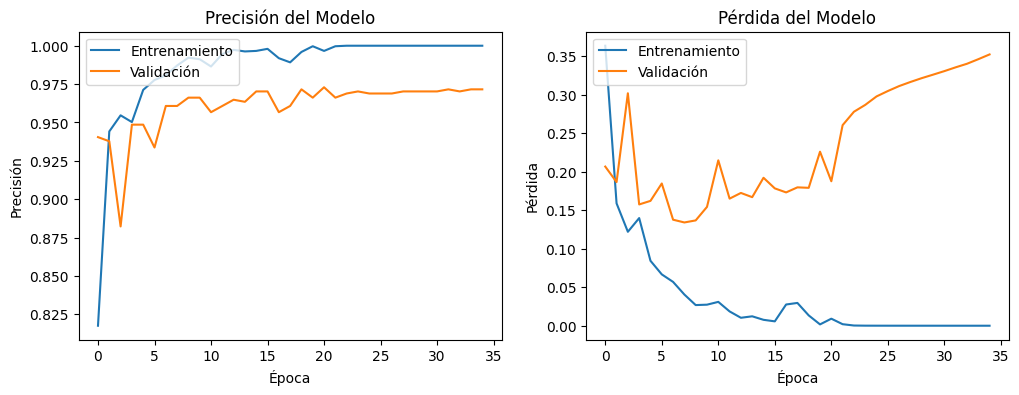

In [40]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step


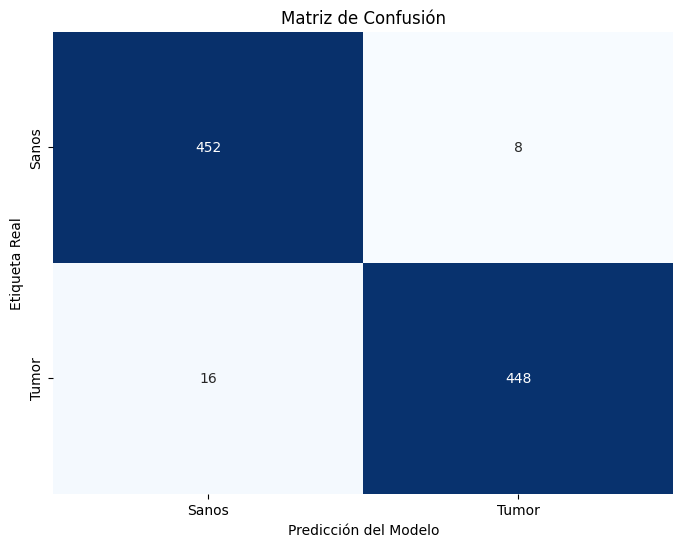

In [41]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo con x capas congeladas

In [63]:
# Cargo el modelo base VGG16 preentrenado en ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [64]:
base_model.trainable = True

capas_a_congelar = 18


for layer in base_model.layers[:capas_a_congelar]:
    layer.trainable = False

In [65]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
#x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
#x = Dense(16, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,883,073 (56.77 MB)

 Trainable params: 168,385 (657.75 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [66]:
history = model.fit(X_train_ct, y_train_ct, epochs=40, batch_size=64, validation_split=0.2)

Epoch 1/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 0.7748 - loss: 0.5064 - val_accuracy: 0.8809 - val_loss: 0.3202
Epoch 2/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8872 - loss: 0.2619 - val_accuracy: 0.9269 - val_loss: 0.2342
Epoch 3/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9305 - loss: 0.1909 - val_accuracy: 0.8985 - val_loss: 0.2978
Epoch 4/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9238 - loss: 0.1970 - val_accuracy: 0.8958 - val_loss: 0.2555
Epoch 5/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9392 - loss: 0.1638 - val_accuracy: 0.9310 - val_loss: 0.2337
Epoch 6/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9488 - loss: 0.1463 - val_accuracy: 0.9215 - val_loss: 0.2372
Epoch 7/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9532 - loss: 0.1365 - val_accuracy: 0.9175 - val_loss: 0.2113
Epoch 8/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9553 - loss: 0.1347 - val_accuracy: 0.9405 -

In [67]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9753 - loss: 0.1067
Pérdida en el conjunto de prueba: 0.1223
Precisión en el conjunto de prueba: 0.9708


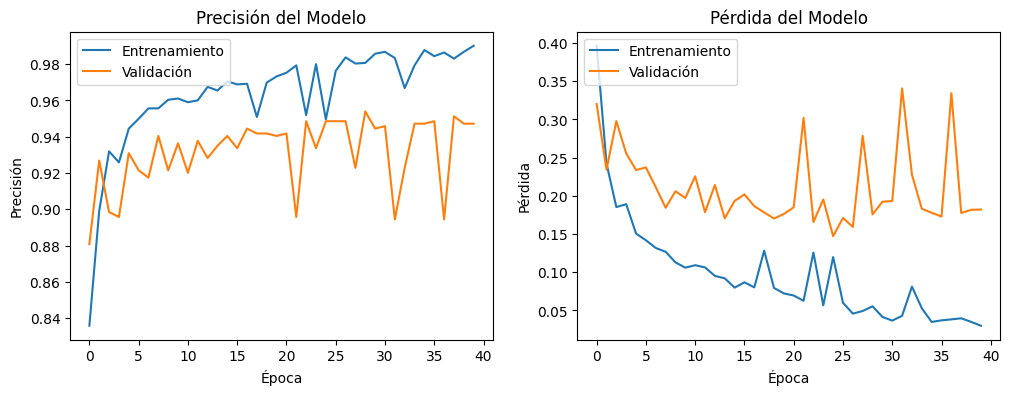

In [68]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step


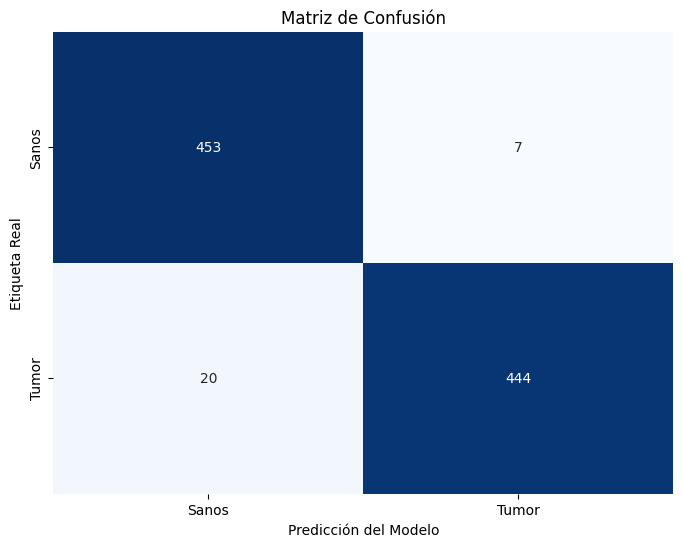

In [69]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo con x capas congeladas

In [77]:
# Cargo el modelo base VGG16 preentrenado en ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [78]:
base_model.trainable = True

capas_a_congelar = 16


for layer in base_model.layers[:capas_a_congelar]:
    layer.trainable = False

In [79]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
#x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
#x = Dense(16, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,883,073 (56.77 MB)

 Trainable params: 4,888,001 (18.65 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [80]:
history = model.fit(X_train_ct, y_train_ct, epochs=25, batch_size=64, validation_split=0.2)

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.7187 - loss: 0.5755 - val_accuracy: 0.8823 - val_loss: 0.3208
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9320 - loss: 0.1851 - val_accuracy: 0.9472 - val_loss: 0.1807
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9577 - loss: 0.1126 - val_accuracy: 0.9513 - val_loss: 0.1579
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9693 - loss: 0.0973 - val_accuracy: 0.9608 - val_loss: 0.1432
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9748 - loss: 0.0869 - val_accuracy: 0.9567 - val_loss: 0.1377
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9815 - loss: 0.0570 - val_accuracy: 0.9648 - val_loss: 0.1382
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9871 - loss: 0.0418 - val_accuracy: 0.9608 - val_loss: 0.1267
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9882 - loss: 0.0454 - val_accuracy: 0.9581 -

In [81]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9789 - loss: 0.1026
Pérdida en el conjunto de prueba: 0.1153
Precisión en el conjunto de prueba: 0.9773


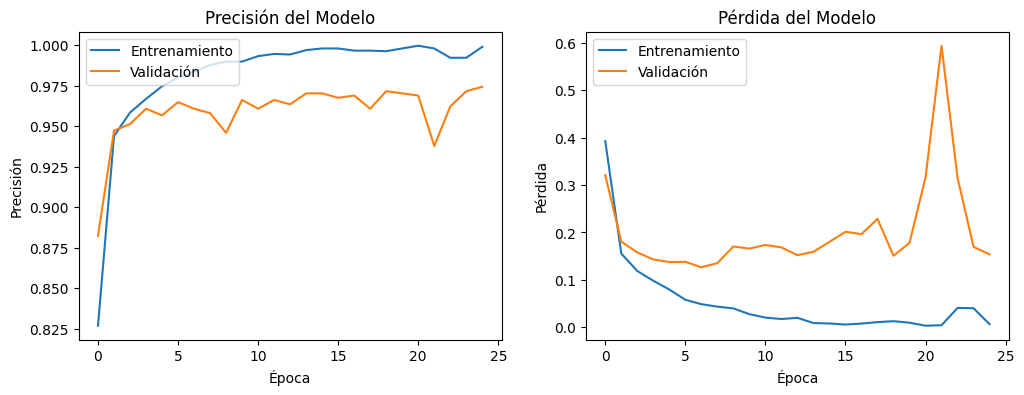

In [82]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step


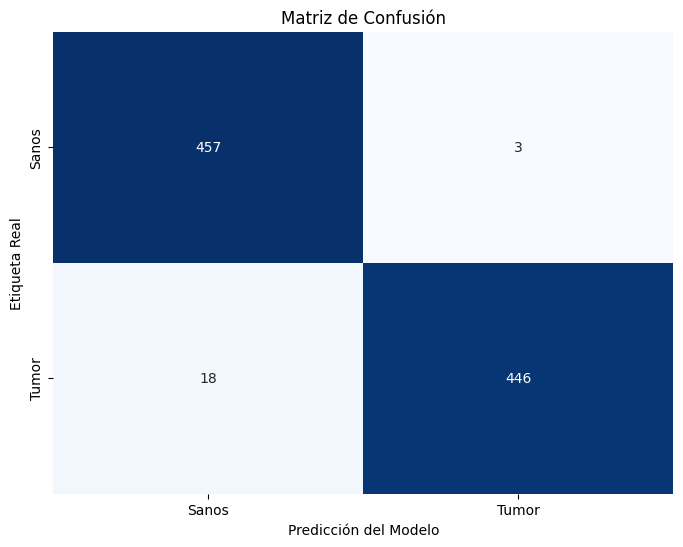

In [83]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

## RESNET 50

### Modelo completo

In [135]:
# Cargo el modelo base ResNet preentrenado en ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [136]:
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_23[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,860,353 (91.02 MB)

 Trainable params: 272,641 (1.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [137]:
history = model.fit(X_train_ct, y_train_ct, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 27s 164ms/step - accuracy: 0.5912 - loss: 0.6597 - val_accuracy: 0.7551 - val_loss: 0.5160
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7856 - loss: 0.4671 - val_accuracy: 0.7848 - val_loss: 0.4643
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8130 - loss: 0.4079 - val_accuracy: 0.8051 - val_loss: 0.4188
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8419 - loss: 0.3594 - val_accuracy: 0.8200 - val_loss: 0.3856
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8405 - loss: 0.3640 - val_accuracy: 0.8146 - val_loss: 0.3913
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8819 - loss: 0.3054 - val_accuracy: 0.8484 - val_loss: 0.3538
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8668 - loss: 0.3235 - val_accuracy: 0.8430 - val_loss: 0.3660
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8607 - loss: 0.3265 - val_accuracy: 

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.8831 - loss: 0.3558
Pérdida en el conjunto de prueba: 0.3474
Precisión en el conjunto de prueba: 0.8874


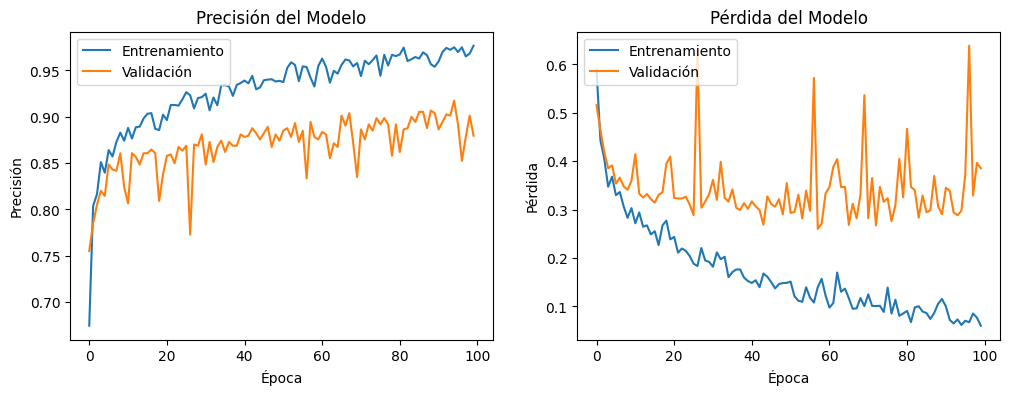

In [138]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step


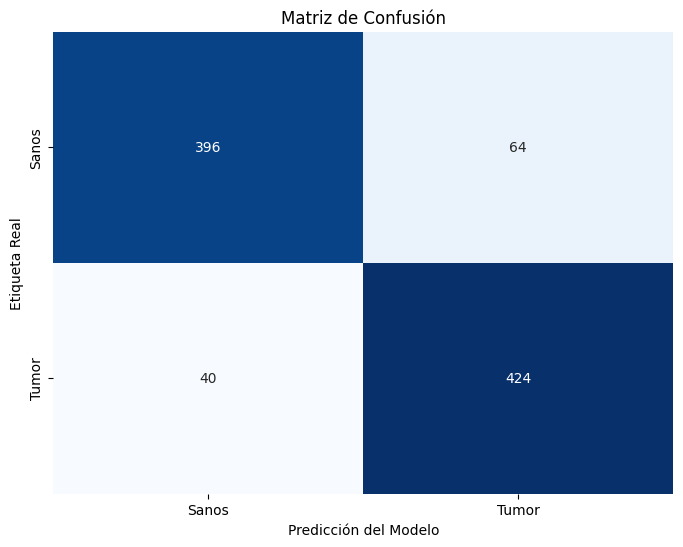

In [139]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()